# **Image classification with transfer learing: single class**

data: cropped celeba 128x128, subset, 60k data, original source https://www.kaggle.com/jessicali9530/celeba-dataset

data augmentation implemented

pretrained model, **Xception** on imagenet dataset

1. re-train all layers of pretrained model 

2. 0.5 dropout

lr=1e-5, 0.95 decay, ~20 epochs

# New Section

In [0]:
#from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os
import math, time, random, datetime


import tensorflow as tf
print(tf.__version__)

#keras = tf.keras
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, EarlyStopping

#import tensorflow_datasets as tfds

2.0.0


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df = pd. read_csv('/content/list_attr_celeba_fay1.csv')
df.head()

In [0]:
y_columns = ['Smiling']
df['image_file'] = 'cr128_' + df['image_id']
df.head()

In [0]:
label_v=df[y_columns].to_numpy()
label_v.sum(axis=1).max()

1

In [0]:
batch_size = 100
HEIGHT = 128
WIDTH = 128
CHAN = 3
nclasses = len(y_columns)

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    channel_shift_range=25.,
    rescale=1./255
        )

datagen_test = ImageDataGenerator(
        rescale=1./255
        )

train_gen = datagen.flow_from_dataframe(dataframe=df[:50000],
                                        directory='/content/celeba_128fay/train/',
                                        x_col='image_file',
                                        y_col='Smiling', 
                                        target_size=(HEIGHT,WIDTH), 
                                        batch_size=batch_size, 
                                        class_mode='other',
                                        shuffle=True,
                                        seed=42)


val_gen = datagen_test.flow_from_dataframe(dataframe=df[50000:60000],
                                        directory='/content/celeba_128fay/test/',
                                        x_col='image_file',
                                        y_col='Smiling', 
                                        target_size=(HEIGHT,WIDTH), 
                                        batch_size=batch_size, 
                                        class_mode='other',
                                        shuffle=False)

test_gen = datagen_test.flow_from_dataframe(dataframe=df[50000:51000],
                                        directory='/content/celeba_128fay/test/',
                                        x_col='image_file',
                                        y_col='Smiling', 
                                        target_size=(HEIGHT,WIDTH), 
                                        batch_size=batch_size, 
                                        class_mode='other',
                                        shuffle=False)



Found 50000 validated image filenames.
Found 10000 validated image filenames.
Found 1000 validated image filenames.


In [0]:
def vector_to_label(label_list, vectors):
  labels=[label_list[i] for i in vectors]
  return labels

label_text = np.array(['Not Smailing','Smailing'])


test_steps = test_gen.n//batch_size
test_gen.reset()
test_images = np.vstack([test_gen.next()[0] for i in range(test_steps)])
test_gen.reset()
test_label = np.hstack([test_gen.next()[1] for i in range(test_steps)])
test_label_text=vector_to_label(label_text, test_label)

In [0]:
n0=0
n=20

plt.figure(figsize=(24, 3*n//10))
for i in range(n0,n0+n):
    count=i+1-n0
    # display original + noise
    plt.subplot(n//10, 10, count)
    plt.imshow(test_images[i].reshape(HEIGHT,WIDTH,CHAN))
    plt.title(test_label_text[i])
    plt.axis('off')

plt.show()

## Pre-trained model + classification head


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape=(HEIGHT, WIDTH, CHAN)),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=nclasses, activation='sigmoid')
])


learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

In [0]:
IMG_SHAPE = (HEIGHT, WIDTH, CHAN) # default 299x299x3

base_model = Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

X = GlobalAveragePooling2D()(base_model.output)
#X = Flatten()(base_model.output)

#X = Dense(64, activation='relu')(X)

X = Dropout(rate=0.5)(X)

OUTPUT = Dense(nclasses, activation='sigmoid')(X)

model = Model(inputs=base_model.input, outputs=OUTPUT)


num_base_layer = len(base_model.layers)

print("Number of layers in the base model: ", num_base_layer)


83689472/83683744 [==============================] - 3s 0us/step
Number of layers in the base model:  132


In [0]:
fine_tune_last = 132 # fine tune some or all layers

base_model.trainable = False

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[num_base_layer-fine_tune_last:]:
    layer.trainable =  True

## set weight
#layer.set_weights(weights)
#keras.initializers.glorot_normal(seed=None)

model.compile(optimizer=Adam(),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

#tf.keras.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

<h3>train model</h3>


In [0]:
#model=load_model('/content/mobilenetv2_celeba128fay50k_100layer_20ep.h5')

In [0]:
lr0=1e-5
annealer = LearningRateScheduler(lambda x: lr0 * 0.95 ** x) 
# 0.95^10=.60, ^20=.36, ^30=.21, ^40=.13

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)


In [0]:
initial_epoch = 0
epochs = 30
steps_per_epoch = train_gen.n//train_gen.batch_size 
validation_steps = val_gen.n//val_gen.batch_size   # 

print("train: steps_per_epoch = ", steps_per_epoch)
print("val:  validation_steps = ", validation_steps)



train: steps_per_epoch =  500
val:  validation_steps =  100


In [0]:
loss0,accuracy0 = model.evaluate_generator(val_gen, steps = validation_steps, verbose=1)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

100/100 [==============================] - 17s 166ms/step - loss: 0.6622 - accuracy: 0.6102
initial loss: 0.66
initial accuracy: 0.61


In [0]:
s0 = time.time()

history = model.fit_generator(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=validation_steps,
        initial_epoch=initial_epoch,
        callbacks=[annealer, es])


s1 = time.time()
print("training time:", time.strftime('%H:%M:%S', time.gmtime(s1 - s0)))

Epoch 1/30
500/500 [==============================] - 343s 686ms/step - loss: 0.4246 - accuracy: 0.8019 - val_loss: 0.2138 - val_accuracy: 0.9125
Epoch 2/30
500/500 [==============================] - 333s 666ms/step - loss: 0.2096 - accuracy: 0.9148 - val_loss: 0.1781 - val_accuracy: 0.9280
Epoch 3/30
500/500 [==============================] - 333s 665ms/step - loss: 0.1842 - accuracy: 0.9224 - val_loss: 0.1713 - val_accuracy: 0.9313
Epoch 4/30
500/500 [==============================] - 332s 663ms/step - loss: 0.1730 - accuracy: 0.9283 - val_loss: 0.1657 - val_accuracy: 0.9323
Epoch 5/30
500/500 [==============================] - 329s 658ms/step - loss: 0.1667 - accuracy: 0.9294 - val_loss: 0.1619 - val_accuracy: 0.9338
Epoch 6/30
500/500 [==============================] - 339s 679ms/step - loss: 0.1593 - accuracy: 0.9329 - val_loss: 0.1587 - val_accuracy: 0.9349
Epoch 7/30
500/500 [==============================] - 341s 681ms/step - loss: 0.1553 - accuracy: 0.9339 - val_loss: 0.1629 -

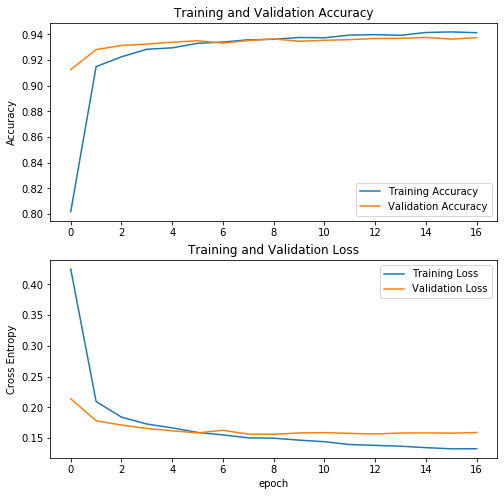

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
gdrive_m="/content/models/"

model.save(gdrive_m + "xception_celeba128fay50k_aug_132lay_20ep.h5")

## **Prediction**



In [0]:
test_gen.reset()
pred = model.predict_generator(test_gen,
                              steps=test_steps,
                              verbose=1)



10/10 [==============================] - 1s 135ms/step


In [0]:
pred_binary = pred.round().astype('int16').reshape(test_gen.n,)

pred_label=vector_to_label(label_text, pred_binary)

In [0]:
correct = ['correct' if t==p else 'incorrect' for t,p in zip(test_label_text, pred_label)]

count=0
for c in correct:
  if c=='correct':
    count+=1

print('acc=',count/len(test_label_text))

acc= 0.932


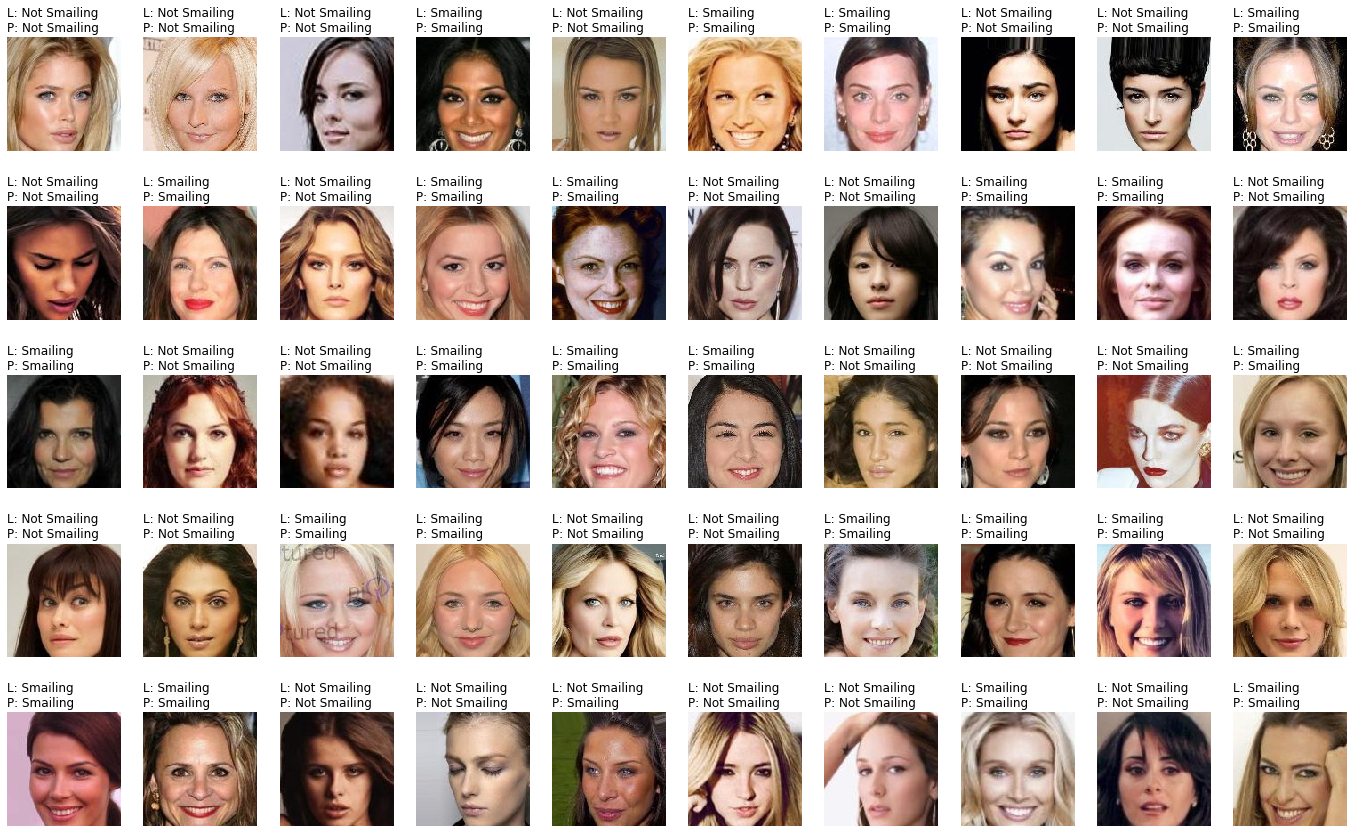

In [0]:
n0=0
n=50

plt.figure(figsize=(24, 3*n//10))
for i in range(n0,n0+n):
    count=i+1-n0
    # display original + noise
    plt.subplot(n//10, 10, count)
    plt.imshow(test_images[i].reshape(HEIGHT,WIDTH,CHAN))
    plt.title('L: ' + test_label_text[i] + '\nP: ' + pred_label[i], loc='left')
    plt.axis('off')

plt.show()




# **References**

source https://www.kaggle.com/jessicali9530/celeba-dataset


load image using image_generator
https://keras.io/preprocessing/image/

https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

guid for transfer learning 
https://www.tensorflow.org/tutorials/images/transfer_learning

good reading
https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41

https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

comparing models
https://keras.io/applications/



